# EX1: Linear regression
 We first consider a simple linear regression model with a Gaussian likelihood. We compute the evidence for the model first with nested sampling, and then with the fourier integration method.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, shutil
import numpy as np
import warnings
from matplotlib import pyplot as plt
import bilby
import logging
from funnel.plotting import plot_fi_evidence_results
from funnel.fi_core import get_fi_lnz_list

CLEAN = False
OUTDIR = 'out_line'

if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

np.random.seed(42)
warnings.filterwarnings("ignore")
logging.getLogger('bilby').setLevel(logging.CRITICAL)

## Generate some data

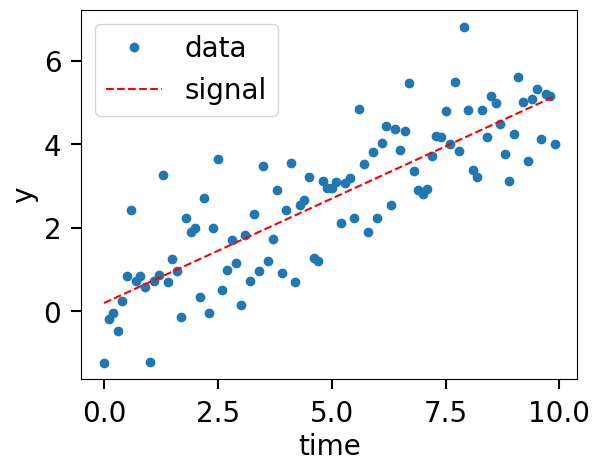

In [3]:
# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c


# Now we define the injection parameters which we make simulated data with
injection_parameters = dict(m=0.5, c=0.2)

sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)
data = model(time, **injection_parameters) + np.random.normal(0, sigma, N)

# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, model(time, **injection_parameters), "--r", label="signal")
ax.set_xlabel("time")
ax.set_ylabel("y")
ax.legend();


## Nested sampling LnZ Calculation

In [4]:
class GaussianLikelihood(bilby.likelihood.Analytical1DLikelihood):
    def __init__(self, x, y, func, sigma=None, **kwargs):
        super(GaussianLikelihood, self).__init__(x=x, y=y, func=func, **kwargs)
        self.sigma = sigma

    def log_likelihood(self):
        return np.sum(- (self.residual / self.sigma) ** 2 / 2 - np.log(2 * np.pi * self.sigma ** 2) / 2)

    def noise_log_likelihood(self):
        return np.sum(- (self.y / self.sigma) ** 2 / 2 - np.log(2 * np.pi * self.sigma ** 2) / 2)


likelihood = GaussianLikelihood(time, data, model, sigma)

priors = bilby.core.prior.PriorDict(dict(
    m=bilby.core.prior.Uniform(0, 5, "m"),
    c=bilby.core.prior.Uniform(-2, 2, "c")
))

label = 'line'
res_fn = f"{OUTDIR}/{label}_result.json"

if os.path.exists(res_fn):
    result = bilby.read_in_result(res_fn)

else:
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=1500,
        outdir=OUTDIR,
        label=label,
        injection_parameters=injection_parameters,
    )
lnz, lnz_err = result.log_evidence, result.log_evidence_err
print(f"LnZ: {lnz:.2f}+/-{lnz_err:.2f}")
print(f"lnBF: {result.log_bayes_factor:.2f}")
result.posterior.head()

LnZ: -143.57+/-0.08
lnBF: 463.04


,m,c,log_likelihood,log_prior
0,0.414940,0.947684,462.024657,-2.995732
1,0.373584,0.777202,462.655885,-2.995732
2,0.631541,-0.471759,462.729253,-2.995732
3,0.457768,0.091686,463.170124,-2.995732
4,0.399787,0.516242,463.372283,-2.995732


In [5]:
class GaussianLikelihoodNoNoiseLikelihood(bilby.likelihood.Analytical1DLikelihood):
    def __init__(self, x, y, func, sigma=None, **kwargs):
        super(GaussianLikelihoodNoNoiseLikelihood, self).__init__(x=x, y=y, func=func, **kwargs)
        self.sigma = sigma

    def log_likelihood(self):
        return np.sum(- (self.residual / self.sigma) ** 2 / 2 - np.log(2 * np.pi * self.sigma ** 2) / 2)

likelihood = GaussianLikelihoodNoNoiseLikelihood(time, data, model, sigma)

priors = bilby.core.prior.PriorDict(dict(
    m=bilby.core.prior.Uniform(0, 5, "m"),
    c=bilby.core.prior.Uniform(-2, 2, "c")
))

label = 'line_wo_noise'
res_fn = f"{OUTDIR}/{label}_result.json"
if os.path.exists(res_fn):
    result = bilby.read_in_result(res_fn)
else:
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=1500,
        outdir=OUTDIR,
        label=label,
        injection_parameters=injection_parameters,
    )
lnz, lnz_err = result.log_evidence, result.log_evidence_err
print(f"LnZ: {lnz:.2f}+/-{lnz_err:.2f}")
print(f"lnBF: {result.log_bayes_factor}")
result.posterior.head()

LnZ: -143.53+/-0.08
lnBF: nan


,m,c,log_likelihood,log_prior
0,0.368069,0.826077,-144.427953,-2.995732
1,0.371618,0.917240,-144.082181,-2.995732
2,0.625413,-0.263018,-144.037430,-2.995732
3,0.509113,-0.172857,-143.003623,-2.995732
4,0.453921,0.129867,-142.954476,-2.995732


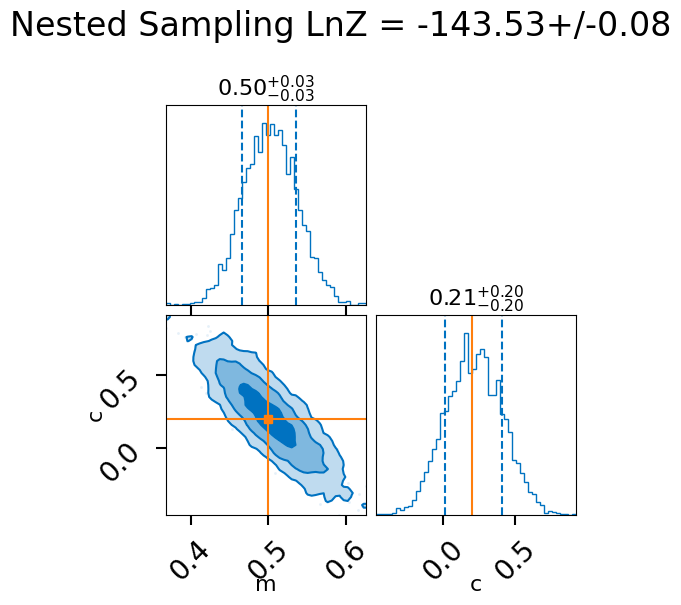

In [6]:
fig = result.plot_corner()
fig.suptitle(f"Nested Sampling LnZ = {lnz:.2f}+/-{lnz_err:.2f}", y=1.1);
fig

NOTE: bilby stores the 'likelihood-ratio' in the `log-likelihood` column when the `noise_log_likelihood` function is defined (compare the posteriors from the above two examples).

## FI LnZ calculation

In [9]:
lnz_file = f"{OUTDIR}/lnz.npz"
lnzs, r_vals, _  = get_fi_lnz_list(result.posterior, num_ref_params=100, cache_file=lnz_file, )

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size: (4020, 2) 


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s, FI LnZ: 0]

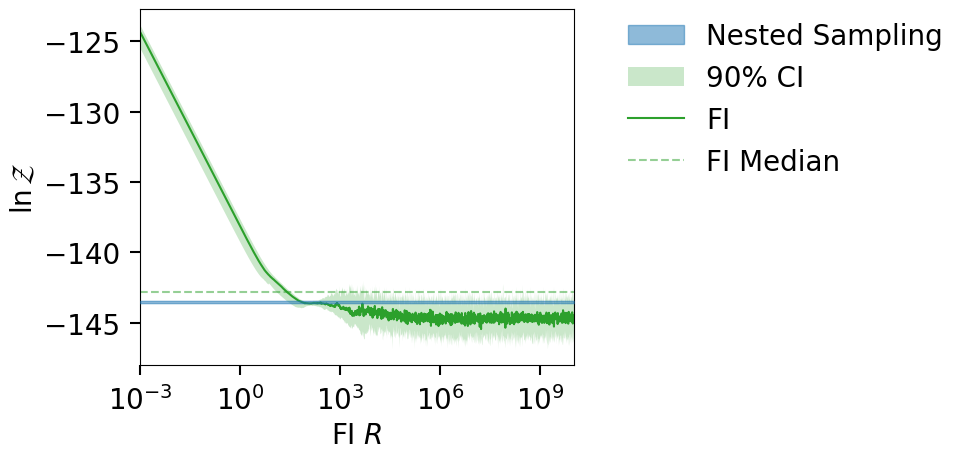

In [10]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals, sampling_lnz=[lnz + lnz_err, lnz - lnz_err], )

fig = plot_fi_evidence_results(**plt_kwgs)
fig.tight_layout()

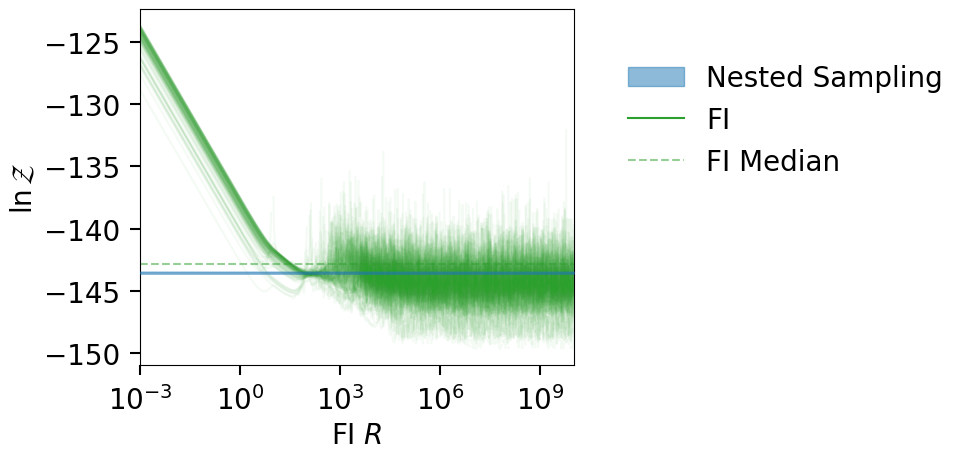

In [11]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True)
fig.tight_layout()

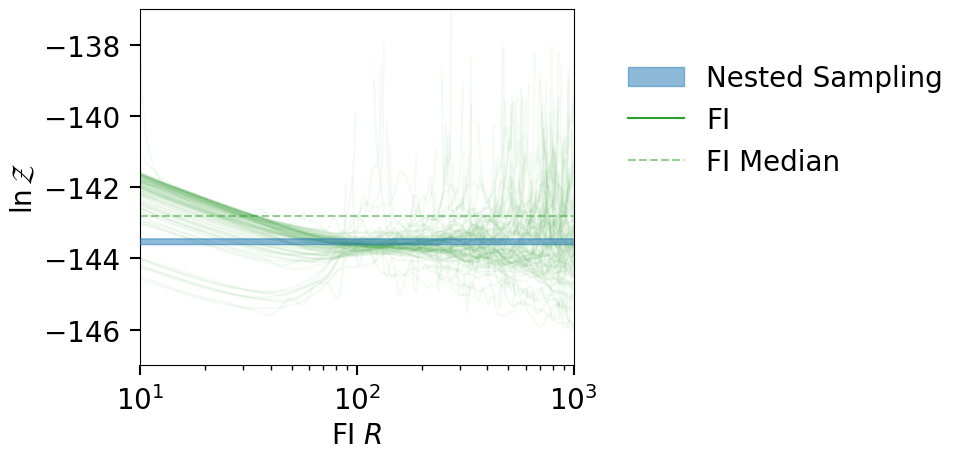

In [12]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True)
ax = fig.gca()
ax.set_xlim(10, 1e3)
ax.set_ylim(-147, -137)
fig.tight_layout()

### Comparing two FI LnZ curves

|funnel|INFO| Calculating FI LnZ with 2 reference points and a posterior of size: (4020, 2) 


FI LnZ:   0%|          | 0/2 [00:00<?, ?it/s, FI LnZ: 0]

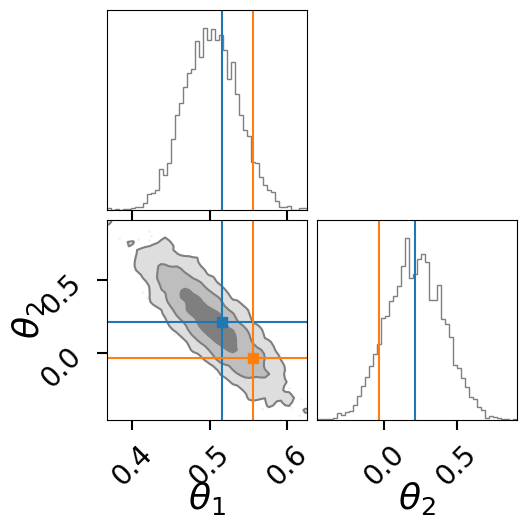

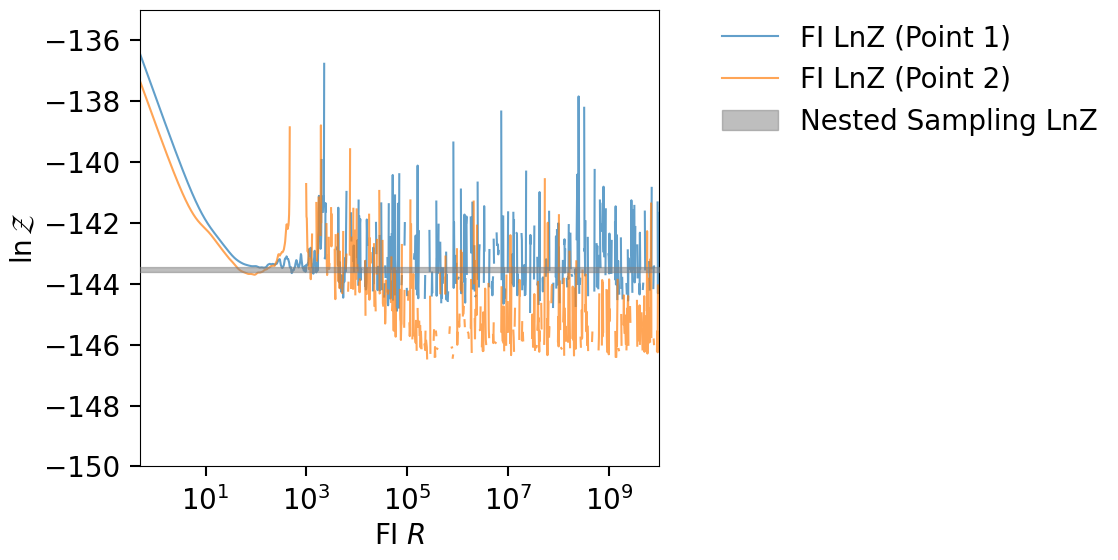

In [13]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

sampling_lnz, sampling_lnz_lnz_err = result.log_evidence, result.log_evidence_err
sampling_lnz = [sampling_lnz + sampling_lnz_lnz_err, sampling_lnz - sampling_lnz_lnz_err]


lnzs, r_vals, fi_samp = get_fi_lnz_list(result.posterior, num_ref_params=2)

plt.figure(figsize=(12, 6))
for i, lnz in enumerate(lnzs):
    plt.plot(r_vals, lnz, label=f"FI LnZ (Point {i + 1})", alpha=0.7)
plt.xscale("log")
plt.xlim(0.5, max(r_vals))
plt.ylim(-150, -135)
plt.xlabel(r"FI $R$")
plt.ylabel(r"$\ln{\mathcal{Z}}$")

plt.fill_between(
            x=r_vals,
            y1=min(sampling_lnz),
            y2=max(sampling_lnz),
            color="tab:gray",
            interpolate=True,
            alpha=0.5,
            label="Nested Sampling LnZ",
            zorder=10,
        )
plt.legend(loc=(1.1, 0.7), frameon=False)
plt.tight_layout()



import corner

fig = result.plot_corner(color="tab:gray", truth=None, label_kwargs={"fontsize": 26}, quantiles=None, labels=[r"$\theta_1$",r"$\theta_2$"])

# overplot the FI points
for i, s in enumerate(fi_samp):
    corner.overplot_lines(fig, s, color=f'C{i}')
    corner.overplot_points(fig, [[np.nan if t is None else t for t in s]],color=f'C{i}', marker='s', markersize=7)
fig

## Finding Optimal R Value and associated LnZ

Lets take the LnZ vs R samples (from _one_ reference point) and identify the point where the LnZ(R) curve turns from a straight line to a flat-line. This is the optimal R value for that reference point.

**Model: Line with negative slope + turning point + flat noise**

In [14]:
import bilby
import matplotlib.pyplot as plt
import pandas as pd


def model(x, m0, c0, var0, var1, turning_point, **kwargs):
    noise0 = np.random.normal(0, np.sqrt(var0), len(x))
    noise1 = np.random.normal(0, np.sqrt(var1), len(x))
    part0 = m0 * x + c0
    part1 = c0 + m0 * turning_point
    return np.where(x < turning_point, part0+noise0, part1+noise1)

def post_processing(df, x, y):
    df['lnz'] = df['turning_point'] * df['m0'] + df['c0']
    df['r'] = np.exp(x[np.argmax(y[:, np.newaxis] <= df['lnz'].values, axis=0)])
    return df



def get_prior(x=[0, 1000]):
    priors = bilby.prior.PriorDict({
        'm0': bilby.prior.Uniform(-3, 0, 'm0'),
        'c0': bilby.prior.Uniform(-150, -130, 'c0'),
        'var0': bilby.prior.LogUniform(1e-5,1, 'var0'),
        'var1': bilby.prior.LogUniform(1e-5, 20, 'var1'),
        'turning_point': bilby.prior.Uniform(min(x), max(x), 'turning_point'),
        'sigma': bilby.core.prior.Uniform(0, 10, "sigma")
    })
    return priors



def plot_two_part_model_samples_and_data(samples_df:pd.DataFrame, x, y):
    fig = plt.figure()
    plt.scatter(x, y, marker='o', color='k', s=0.1, zorder=10)
    if 'lnz' not in samples_df:
        samples_df = post_processing(samples_df, x, y)
    samps = samples_df.to_dict('records')
    for s in samps:
        plt.plot(x, model(x, **s), color='C0', alpha=0.1)
        plt.axhline(s['lnz'], color='C1', alpha=0.3, zorder=-100)
        plt.axvline(np.log(s['r']), color='C2', alpha=0.3, zorder=-100)

    lnz_str = get_median_and_error_str(samples_df['lnz'])
    r_str = get_median_and_error_str(samples_df['r'])
    plt.plot([],[], color="k", label="Data")
    plt.plot([],[], color="C0", label="2-part model")
    plt.plot([],[], color="C1", label="LnZ: "+lnz_str)
    plt.plot([],[], color="C2", label="R: "+r_str)
    plt.legend(loc='upper right', fontsize=12)
    
    plt.xlim(min(x), max(x))
    plt.ylim(min(y), max(y));
    plt.xlabel(r"$\ln R$")
    plt.ylabel(r"$\ln\mathcal{Z}$")
    return fig

def get_median_and_error_str(s:np.array):
    med = np.median(s)
    upper = np.percentile(s, 84) - med
    lower = med - np.percentile(s, 16)
    fmt = "{:.2f}".format
    s = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
    s = s.format(fmt(med), fmt(lower), fmt(upper))
    return s


class GaussianLikelihoodIgnoreNan(bilby.likelihood.GaussianLikelihood):
    def __init__(self, x, y, func, sigma=None, **kwargs):
        super(GaussianLikelihoodIgnoreNan, self).__init__(x=x, y=y, func=func, **kwargs)
        self.sigma = sigma

    def log_likelihood(self):
        return np.nansum(- (self.residual / self.sigma) ** 2 / 2 - np.log(2 * np.pi * self.sigma ** 2) / 2)



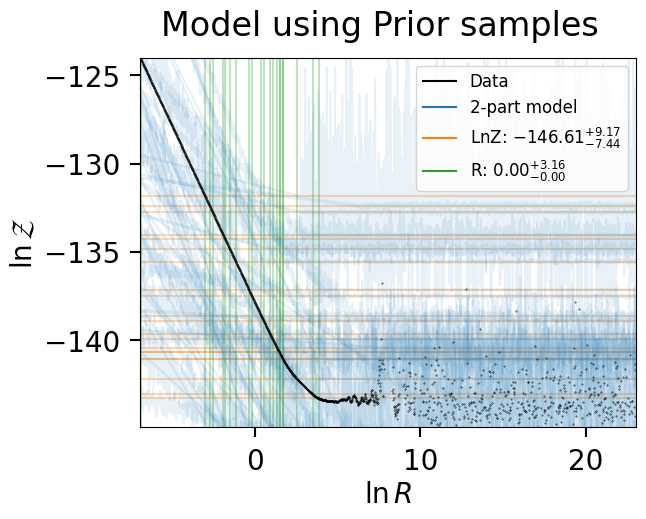

In [15]:
priors = get_prior([0,10])

x = np.log(r_vals)
y = lnzs[0]
fig = plot_two_part_model_samples_and_data(pd.DataFrame(priors.sample(50)), x, y)
fig.suptitle("Model using Prior samples")
fig.show()

In [16]:
likelihood = GaussianLikelihoodIgnoreNan(x, y, model)

# test that we're not getting nans
for i in range(10):
    sample = priors.sample(1)
    likelihood.parameters.update(sample)
    assert np.isfinite(likelihood.log_likelihood()), "Likelihood --> nan!!"

### MCMC 100 steps

In [17]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler='emcee',
    nsteps=100,
    outdir='outdir',
    label='example',
    clean=True
)
result.posterior = post_processing(result.posterior, x, y)

  0%|          | 0/100 [00:00<?, ?it/s]

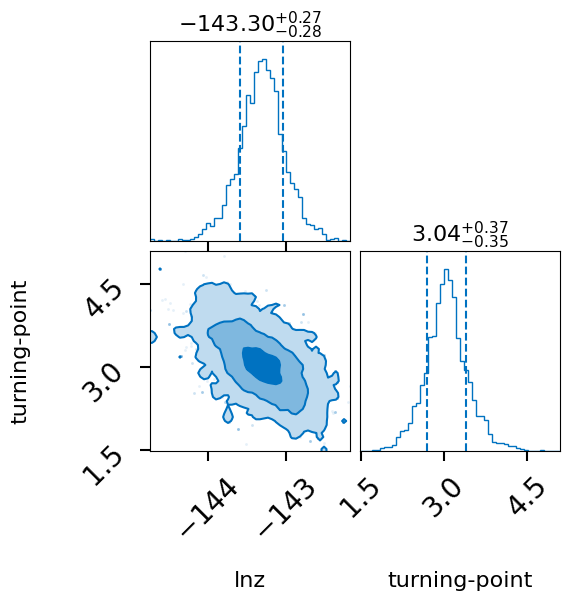

In [18]:
result.plot_corner(parameters=['lnz','turning_point'], labelpad=0.3)

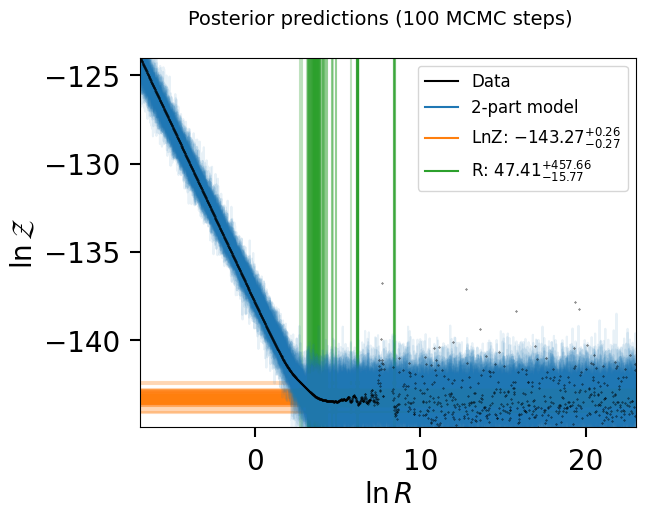

In [19]:
fig = plot_two_part_model_samples_and_data(result.posterior.sample(100), x, y)
fig.suptitle("Posterior predictions (100 MCMC steps)", fontsize=14)
fig.show()

### MCMC 1000 Steps

In [20]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler='emcee',
    nsteps=1000,
    outdir='outdir',
    label='example',
    clean=True
)
result.posterior = post_processing(result.posterior, x, y)

  0%|          | 0/1000 [00:00<?, ?it/s]

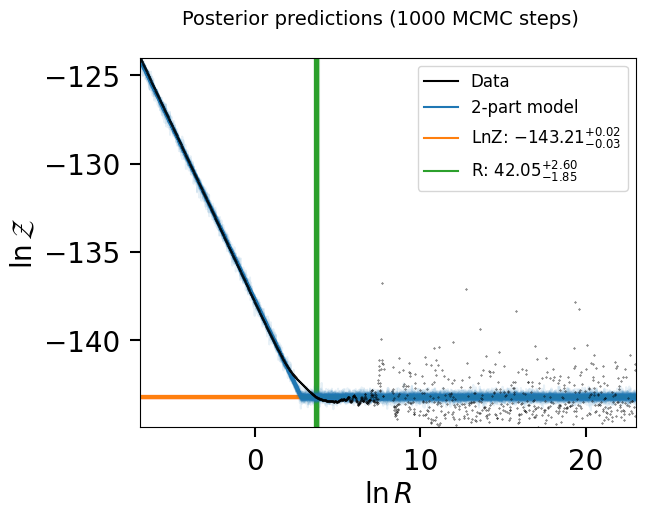

In [21]:
fig = plot_two_part_model_samples_and_data(result.posterior.sample(100), x, y)
fig.suptitle("Posterior predictions (1000 MCMC steps)", fontsize=14)
fig.show()

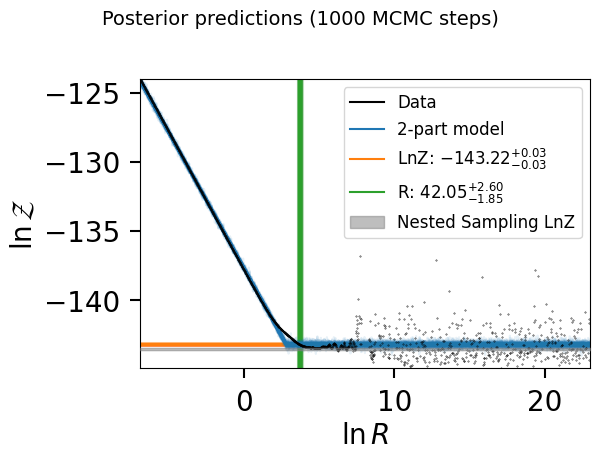

In [30]:
fig = plot_two_part_model_samples_and_data(result.posterior.sample(100), x, y)
plt.fill_between(
            x=x,
            y1=min(sampling_lnz),
            y2=max(sampling_lnz),
            color="tab:gray",
            interpolate=True,
            alpha=0.5,
            label="Nested Sampling LnZ",
            zorder=10,
        )
ax  = fig.gca()
ax.get_legend().remove()
ax.legend(fontsize=12, loc='upper right')
fig.suptitle("Posterior predictions (1000 MCMC steps)", fontsize=14)
fig.tight_layout()
fig.show()